In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
transformer_train = torchvision.transforms.Compose([
    # torchvision.transforms.ColorJitter(
    #     brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2
    # ),
    transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    # torchvision.transforms.RandomRotation(degrees=15),
    torchvision.transforms.RandomAffine(0, translate=(0.1,0.1)),
    # torchvision.transforms.RandomPerspective(),
    transforms.ToTensor
])
train_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
test_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [3]:
# Behaves differently from MNIST / Fashion MNIST
# it is a Numpy array
train_dataset.data

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [4]:
# we are working with color images now
train_dataset.data.shape

(50000, 32, 32, 3)

In [5]:
# Behaves differently from MNIST / Fashion MNIST
# it is a list
train_dataset.targets[:5]

[6, 9, 9, 4, 1]

In [6]:
# number of classes
K = len(set(train_dataset.targets))
print(f'number of classes: {K}')

number of classes: 10


In [7]:
# Data loader
# Usefull because it automatically generates batches in the training loop
# and takes care of shuffling
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [8]:
# the data transformer mapped the data to (0,1)
# and also moved the color channel before height/width
tmp_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=1,
    shuffle=True
)

for x,y in tmp_loader:
  print(x)
  print(x.shape)
  break

tensor([[[[0.5725, 0.5647, 0.5922,  ..., 0.3961, 0.4392, 0.6157],
          [0.4745, 0.5529, 0.5725,  ..., 0.4078, 0.4000, 0.5608],
          [0.4627, 0.5255, 0.5529,  ..., 0.3843, 0.3765, 0.5412],
          ...,
          [0.4471, 0.4549, 0.4510,  ..., 0.3765, 0.3725, 0.3804],
          [0.4471, 0.4784, 0.4353,  ..., 0.3686, 0.4078, 0.3765],
          [0.4471, 0.4706, 0.4353,  ..., 0.4431, 0.4902, 0.4941]],

         [[0.5765, 0.5922, 0.6157,  ..., 0.3765, 0.4196, 0.6392],
          [0.4745, 0.5882, 0.6039,  ..., 0.3882, 0.3765, 0.5843],
          [0.4627, 0.5529, 0.5765,  ..., 0.3725, 0.3490, 0.5569],
          ...,
          [0.4784, 0.4588, 0.4667,  ..., 0.3608, 0.3490, 0.3608],
          [0.4627, 0.4863, 0.4510,  ..., 0.3725, 0.4000, 0.3647],
          [0.4275, 0.4549, 0.4314,  ..., 0.4431, 0.4745, 0.4627]],

         [[0.5725, 0.6118, 0.6392,  ..., 0.3333, 0.3882, 0.6784],
          [0.4784, 0.6235, 0.6510,  ..., 0.3529, 0.3412, 0.6039],
          [0.4667, 0.6039, 0.6275,  ..., 0

In [9]:
from torch.nn.modules.pooling import MaxPool2d
# Define the model\
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()
    # define the conv layers
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
    )
    # Useful: https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d
    # H_out = H_in + 2p - 2 --> p = 1 if H_out = H_in

    # Easy to calculate output
    # 32 > 16 > 8 > 4

    # define the linear layers
    self.fc1 = nn.Linear(128 * 4 * 4, 1024)
    self.fc2 = nn.Linear(1024, K)

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), -1)
    x = F.dropout(x, p=0.5)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.5)
    x = self.fc2(x)
    return x

In [10]:
# Instantiate the model
model = CNN(K)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [13]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=1000):
  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)
  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zer0 the parameter gradients
      optimizer.zero_grad()

      # forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading

    model.eval()

    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}")


  return train_losses, test_losses

In [14]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader,
                                     epochs=80)

Epoch 1/80, Train Loss: 1.3256, Test Loss: 1.0186, Duration: 0:00:19.590158
Epoch 2/80, Train Loss: 0.8932, Test Loss: 0.8910, Duration: 0:00:12.373521
Epoch 3/80, Train Loss: 0.7342, Test Loss: 0.7874, Duration: 0:00:12.386014
Epoch 4/80, Train Loss: 0.6390, Test Loss: 0.7525, Duration: 0:00:12.357691
Epoch 5/80, Train Loss: 0.5665, Test Loss: 0.7597, Duration: 0:00:13.405336
Epoch 6/80, Train Loss: 0.5095, Test Loss: 0.6997, Duration: 0:00:12.995338
Epoch 7/80, Train Loss: 0.4532, Test Loss: 0.6932, Duration: 0:00:13.859150
Epoch 8/80, Train Loss: 0.4090, Test Loss: 0.7010, Duration: 0:00:12.423608
Epoch 9/80, Train Loss: 0.3815, Test Loss: 0.6771, Duration: 0:00:12.500653
Epoch 10/80, Train Loss: 0.3430, Test Loss: 0.6518, Duration: 0:00:12.551520
Epoch 11/80, Train Loss: 0.3233, Test Loss: 0.6449, Duration: 0:00:12.842077
Epoch 12/80, Train Loss: 0.2971, Test Loss: 0.7374, Duration: 0:00:12.647093
Epoch 13/80, Train Loss: 0.2838, Test Loss: 0.6757, Duration: 0:00:12.557813
Epoch 14

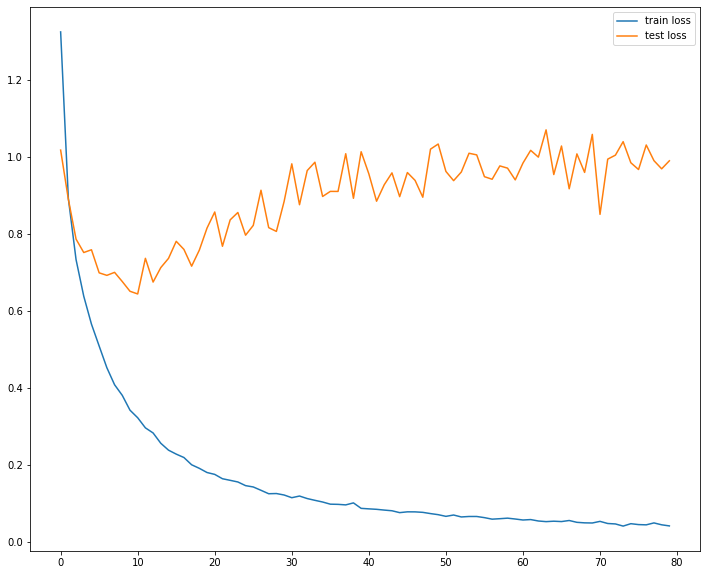

In [15]:
# plot the train loss and test loss per iteration
plt.figure(figsize=(12,10))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [16]:
# Accuracy

model.eval()
n_correct = 0
n_total = 0
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)
  # forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct/n_total

n_correct = 0
n_total = 0
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)
  # forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct/n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9874, Test acc: 0.8356


In [17]:
from prompt_toolkit.layout.containers import HorizontalAlign
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'.
  """
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  print(f"{cm}\n")
  plt.figure(figsize=(12,10))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],fmt),
             horizontalalignment='center',
             color='white' if cm[i,j] > thresh else 'black')
    
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[847  13  35  11   5   3   8  11  49  18]
 [ 11 933   2   0   1   2   4   0  14  33]
 [ 59   2 751  44  46  25  40  18  10   5]
 [ 20   8  41 696  52  92  45  24   9  13]
 [  9   1  38  35 834  13  34  30   4   2]
 [ 12   3  33 113  40 751  14  30   1   3]
 [  9   2  34  37  16  11 880   6   4   1]
 [ 17   6  19  28  37  30   3 853   2   5]
 [ 33  24   5   9   5   1   5   3 902  13]
 [ 21  60   5   7   2   1   5   3  16 880]]



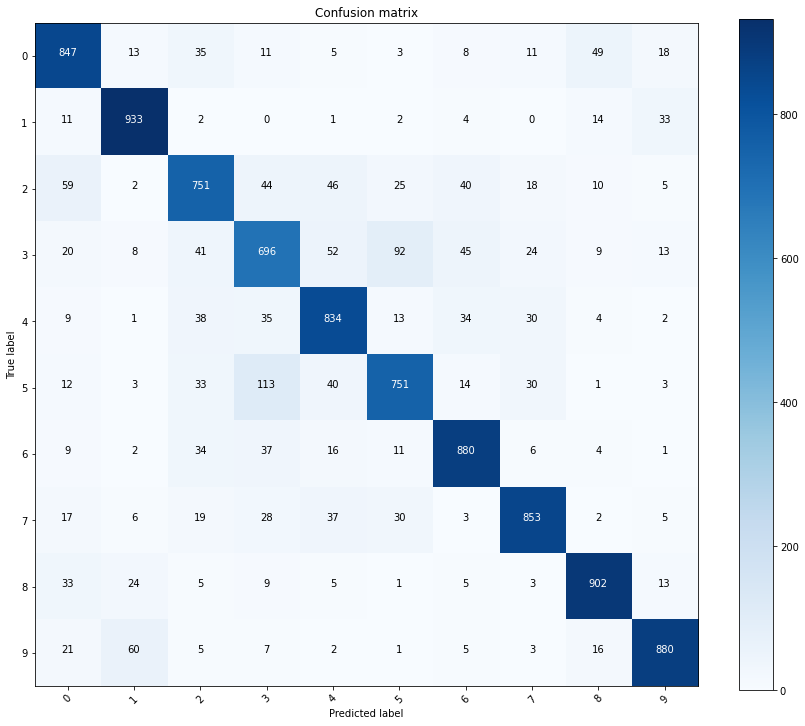

In [18]:
# Get all predictions in an array and plot confusiuon matrix

x_test = test_dataset.data
y_test = test_dataset.targets
p_test = np.array([])
for inputs, targets in test_loader:
  # move data to GPU
  inputs = inputs.to(device)
  # forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test,p_test)
plot_confusion_matrix(cm,list(range(10)))

In [19]:
# Label mapping
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split('\n')
labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

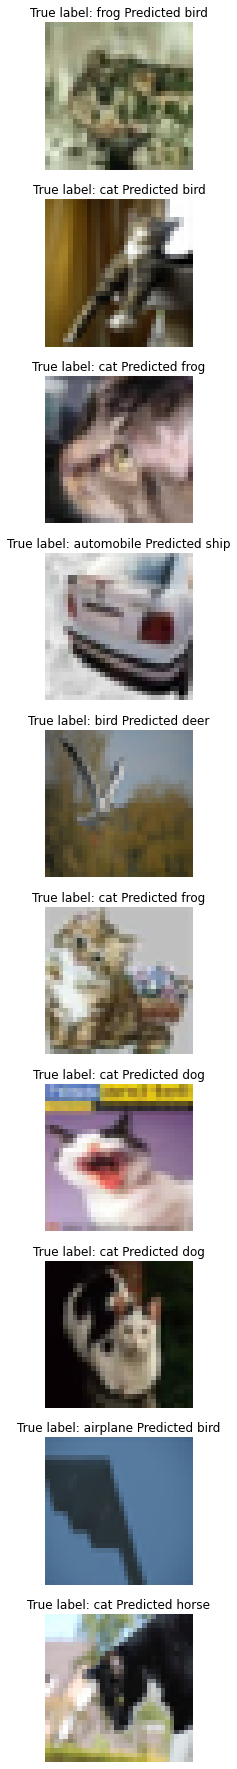

In [20]:
# show some misclassified examples
p_test = p_test.astype(np.uint8)
misclassifed_idx = np.where(p_test != y_test)[0]
sample_idx = np.random.choice(misclassifed_idx, 10, replace=False)
plt.figure(figsize=(32,32))
for j, i in enumerate(sample_idx):
  plt.subplot(10, 1, j+1)
  plt.axis('off')
  plt.imshow(x_test[i], cmap='gray')
  plt.title("True label: %s Predicted %s" % (labels[y_test[i]], labels[p_test[i]]))

In [21]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
              ReLU-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
        MaxPool2d-14             [-1, 6